# 0. Importing data and Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans,SpectralClustering,DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from wordcloud import WordCloud,STOPWORDS
from sklearn import manifold

In [3]:
sys.path.insert(0, "../functions")
#self defined functions
import data_processing as dp

In [4]:
mlb = pd.read_csv("../data/tidied_text_added.csv")


In [5]:
mlb.head()

Unnamed: 0                   Datetime             Tweet Id  \
0           0  2021-12-30 23:59:47+00:00  1476704601424465921   
1           1  2021-12-30 23:54:30+00:00  1476703271221878793   
2           2  2021-12-30 23:34:26+00:00  1476698220176814081   
3           3  2021-12-30 23:24:16+00:00  1476695662930501633   
4           4  2021-12-30 23:20:33+00:00  1476694729270071302   

                                                Text         Username  \
0  That's is if we're allowed #Baseball ever agai...   LittlePickles9   
1  Joining @RR_RicardoFAN next is @dcone36 to dis...   CBSSportsRadio   
2         When do you think the MLB Lockout is over?   NYYSportsfan96   
3  WHEN IS THE MLB LOCKOUT GOING TO BE OVER ‼️‼️‼...        itstitoo_   
4  MLB lockout mailbag: Major sticking points, po...  JenniferHeiner_   

   Reply Count  Retweet Count  Like Count  tweetquote Count  \
0            0              0           0                 0   
1            0              2           6                 0   
2            0              0           0                 0   
3            0              0           0                 0   
4            0              0           0                 0   

       conversation ID                                             source  \
0  1476704601424465921  <a href="http://twitter.com/download/android" ...   
1  1476703271221878793  <a href="https://mobile.twitter.com" rel="nofo...   
2  1476698220176814081  <a href="https://mobile.twitter.com" rel="nofo...   
3  1476695662930501633  <a href="http://twitter.com/download/android" ...   
4  1476694729270071302  <a href="https://dlvrit.com/" rel="nofollow">d...   

   retweeted Tweet                                        quotedTweet  \
0              NaN  https://twitter.com/LittlePickles9/status/1476...   
1              NaN                                                NaN   
2              NaN                                                NaN   
3              NaN                                                NaN   
4              NaN                                                NaN   

                                     mentioned Users language  \
0                                                NaN       en   
1  [User(username='RR_RicardoFAN', id=23912945, d...       en   
2                                                NaN       en   
3                                                NaN       en   
4                                                NaN       en   

                             hashtag                       mentioned  \
0  ['#baseball', '#mlb', '#lockout']                              []   
1                                 []  ['@rr_ricardofan', '@dcone36']   
2                                 []                              []   
3                                 []                              []   
4                                 []                              []   

                                        cleaned_text  \
0                  allowed baseball ever mlb lockout   
1  joining rr_ricardofan next dcone36 discuss mlb...   
2                                  think mlb lockout   
3                                  mlb lockout going   
4  mlb lockout mailbag major sticking points pote...   

                                   cleaned_text_list  
0    ['ever', 'baseball', 'lockout', 'allow', 'mlb']  
1  ['need', 'join', 'discuss', 'start', 'time', '...  
2                        ['lockout', 'think', 'mlb']  
3                           ['lockout', 'mlb', 'go']  
4  ['point', 'train', 'stick', 'delay', 'mailbag'...

# 1. tf-idf vectorization

In [6]:
# removing words that are overwhemenly existing in the text
common_words_removed = [dp.remove_stopwords(sentence, ["mlb", "lockout", "mlblockout","baseball","today","day"])
 for sentence in mlb.cleaned_text]


In [7]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(common_words_removed)


In [9]:
X_dense = X.todense()
X_dense.shape


(41243, 7587)

# 2. Dimension Reduction

- Baseline Model (Model 1): Linear Dimension Reduction (PCA)  <br>
    - Features for fine tuning:  <br>
        - number of principle components <br>
        - initial tf-idf vector input <br>
- Non-Linear Model: ISO-map



### 2.0. Kmeans without any reduction

In [ ]:
# initialize KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=25)
kmeans.fit(X)
clusters = kmeans.labels_


In [ ]:
len(clusters)

41243

In [ ]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(
        clusters).mean()  # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out()  # access tf-idf terms
    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        # for each row of the dataframe, find the n terms that have the highest tf idf score
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))


In [ ]:
get_top_keywords(10)


Cluster 0
great,would,already,soon,want,needs,waiting,please,need,end

Cluster 1
time,league,rob,fans,get,season,manfred,owners,players,mlbpa

Cluster 2
fail,manfred,cancels,regular,season,delayed,start,games,training,spring


**Starting with typical 2-dimensional PCA**

In [ ]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=19)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [ ]:
mlb['cluster'] = clusters
mlb['x0'] = x0
mlb['x1'] = x1


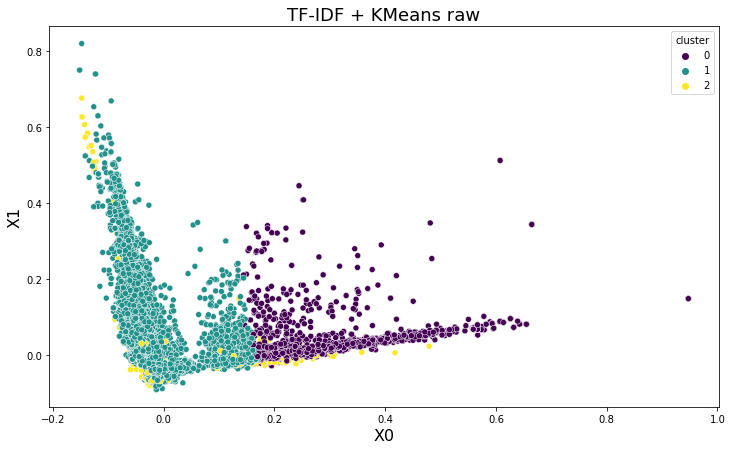

In [ ]:
# set image size
plt.figure(figsize=(12, 7))
# set title
plt.title("TF-IDF + KMeans raw",
          fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
#  create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=mlb, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()


In [ ]:
# kmeans = KMeans(n_clusters=3, random_state=25)
kmeans.fit(pca_vecs)
clusters2 = kmeans.labels_
mlb['cluster2'] = clusters2


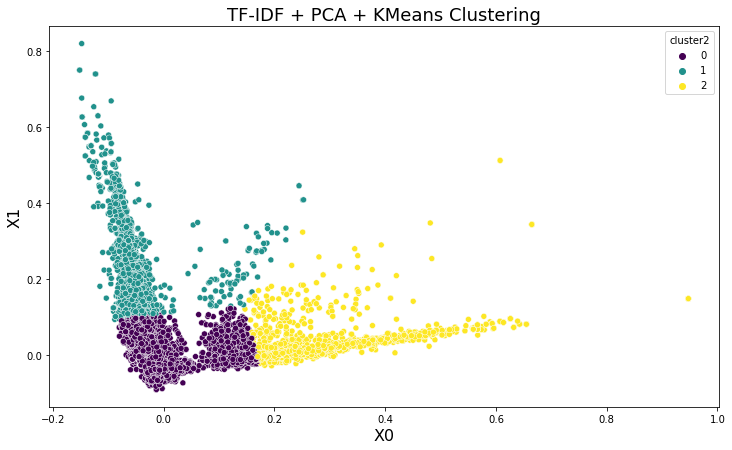

In [ ]:
# set image size
plt.figure(figsize=(12, 7))
# set title
plt.title("TF-IDF + PCA + KMeans Clustering",
          fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
#  create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=mlb, x='x0', y='x1', hue='cluster2', palette="viridis")
plt.show()


In [ ]:
mlb[mlb.cluster2==0].head()

Unnamed: 0                   Datetime             Tweet Id  \
0           0  2021-12-30 23:59:47+00:00  1476704601424465921   
1           1  2021-12-30 23:54:30+00:00  1476703271221878793   
2           2  2021-12-30 23:34:26+00:00  1476698220176814081   
3           3  2021-12-30 23:24:16+00:00  1476695662930501633   
4           4  2021-12-30 23:20:33+00:00  1476694729270071302   

                                                Text         Username  \
0  That's is if we're allowed #Baseball ever agai...   LittlePickles9   
1  Joining @RR_RicardoFAN next is @dcone36 to dis...   CBSSportsRadio   
2         When do you think the MLB Lockout is over?   NYYSportsfan96   
3  WHEN IS THE MLB LOCKOUT GOING TO BE OVER ‼️‼️‼...        itstitoo_   
4  MLB lockout mailbag: Major sticking points, po...  JenniferHeiner_   

   Reply Count  Retweet Count  Like Count  tweetquote Count  \
0            0              0           0                 0   
1            0              2           6                 0   
2            0              0           0                 0   
3            0              0           0                 0   
4            0              0           0                 0   

       conversation ID  ...  \
0  1476704601424465921  ...   
1  1476703271221878793  ...   
2  1476698220176814081  ...   
3  1476695662930501633  ...   
4  1476694729270071302  ...   

                                     mentioned Users  language  \
0                                                NaN        en   
1  [User(username='RR_RicardoFAN', id=23912945, d...        en   
2                                                NaN        en   
3                                                NaN        en   
4                                                NaN        en   

                             hashtag                       mentioned  \
0  ['#baseball', '#mlb', '#lockout']                              []   
1                                 []  ['@rr_ricardofan', '@dcone36']   
2                                 []                              []   
3                                 []                              []   
4                                 []                              []   

                                        cleaned_text  \
0                  allowed baseball ever mlb lockout   
1  joining rr_ricardofan next dcone36 discuss mlb...   
2                                  think mlb lockout   
3                                  mlb lockout going   
4  mlb lockout mailbag major sticking points pote...   

                                   cleaned_text_list cluster        x0  \
0    ['ever', 'baseball', 'lockout', 'allow', 'mlb']       1 -0.004665   
1  ['need', 'join', 'discuss', 'start', 'time', '...       1  0.157051   
2                        ['lockout', 'think', 'mlb']       1  0.004124   
3                           ['lockout', 'mlb', 'go']       1  0.006078   
4  ['point', 'train', 'stick', 'delay', 'mailbag'...       2 -0.025924   

         x1  cluster2  
0 -0.033517         0  
1  0.008061         0  
2 -0.028388         0  
3 -0.051269         0  
4 -0.041203         0  

[5 rows x 23 columns]

In [ ]:
bubble = pd.Series(mlb[mlb.cluster2 == 0].cleaned_text).str.cat(sep=' ')


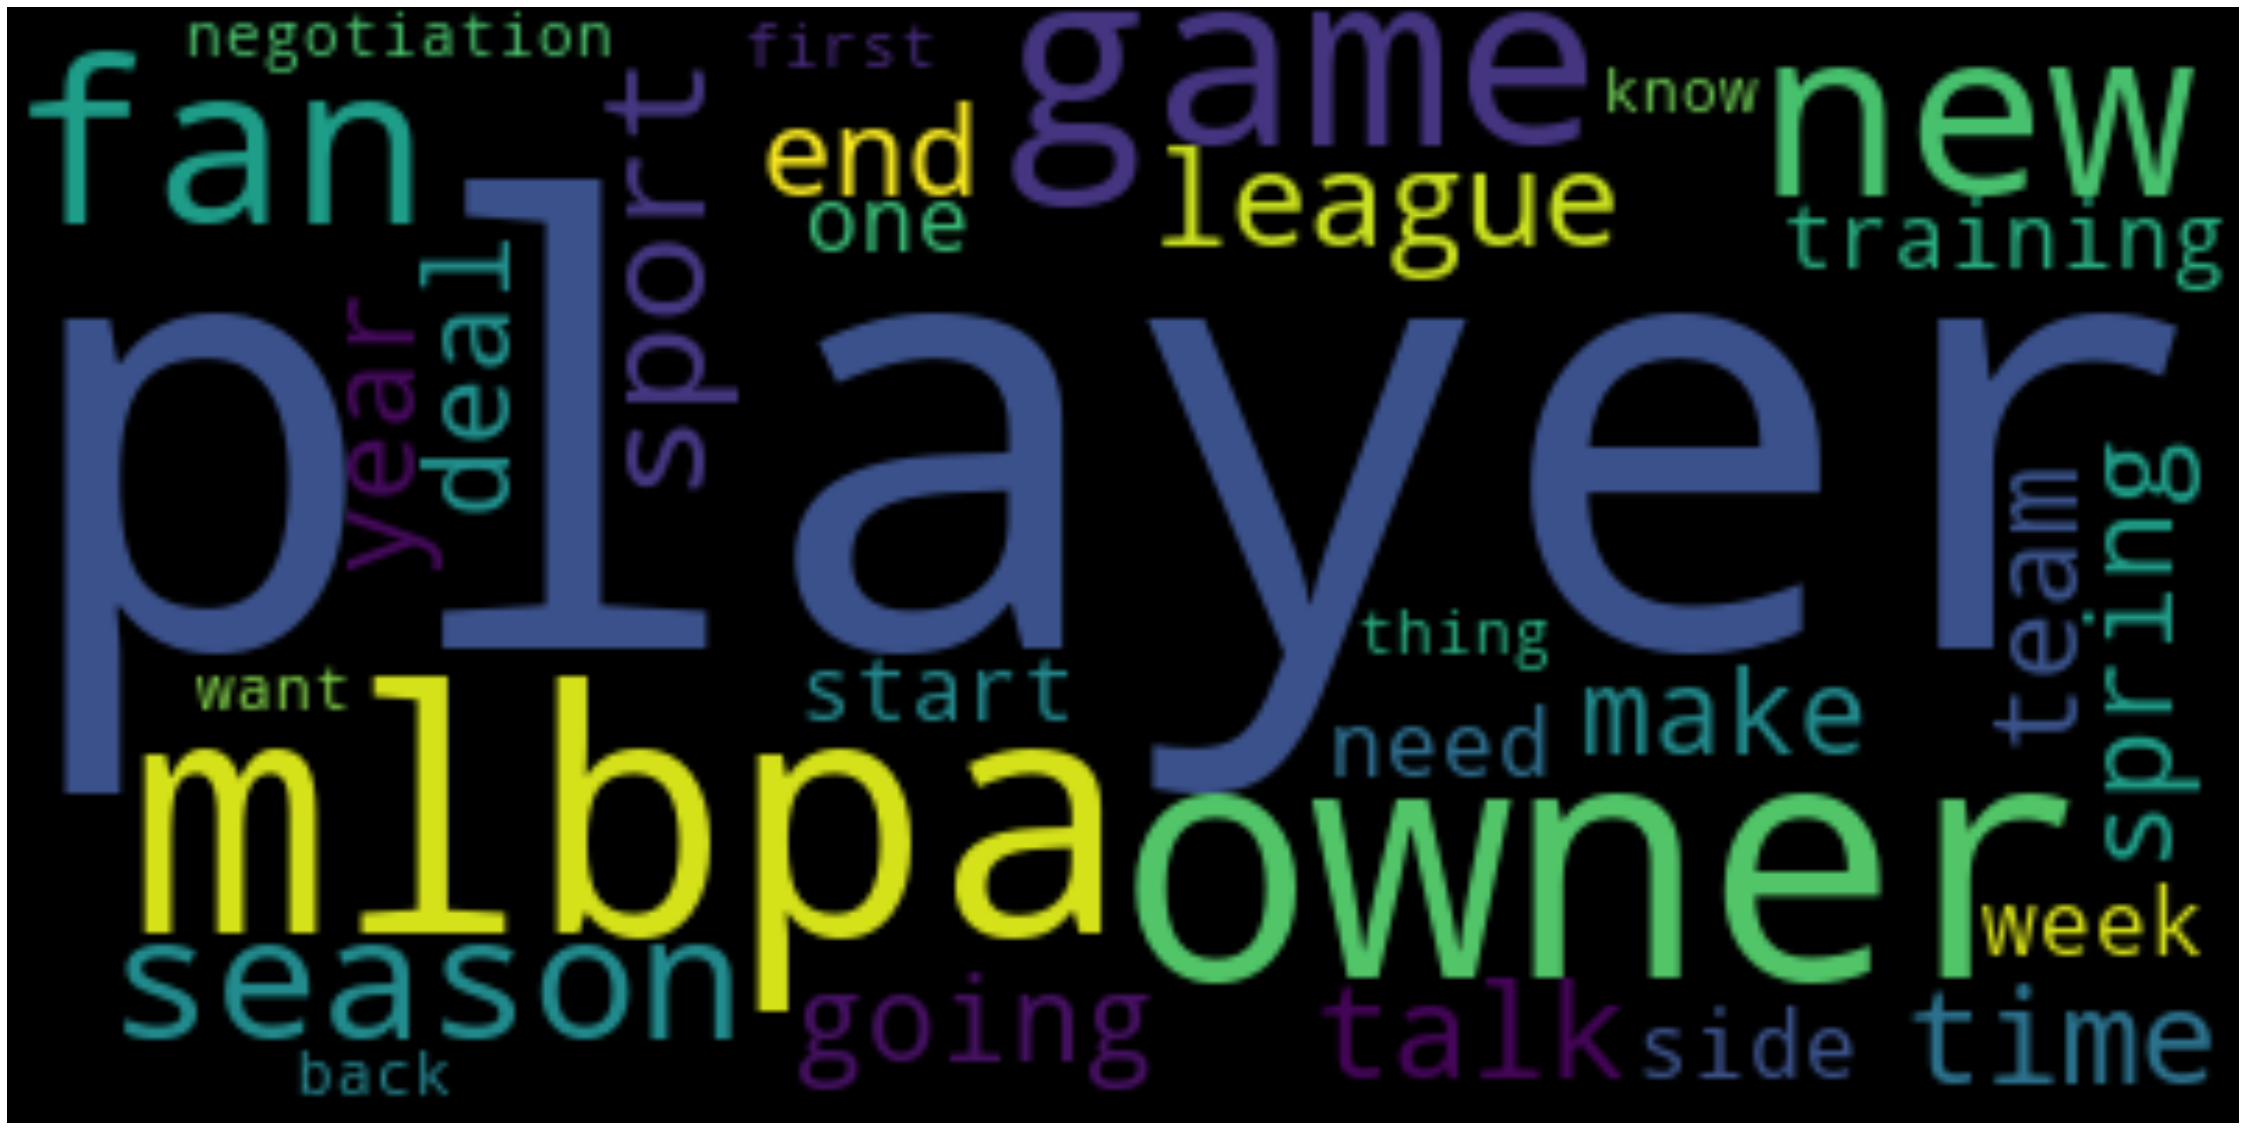

In [ ]:
stopwords = set(STOPWORDS)
stopwords.update(["mlb", "lockout", "mlblockout", "baseball", "today", "day"])
wordcloud = WordCloud( stopwords=stopwords, max_font_size=200,
                      max_words=30, collocations=False, background_color='black').generate(bubble)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
bubble2 = pd.Series(mlb[mlb.cluster2 == 1].cleaned_text).str.cat(sep=' ')


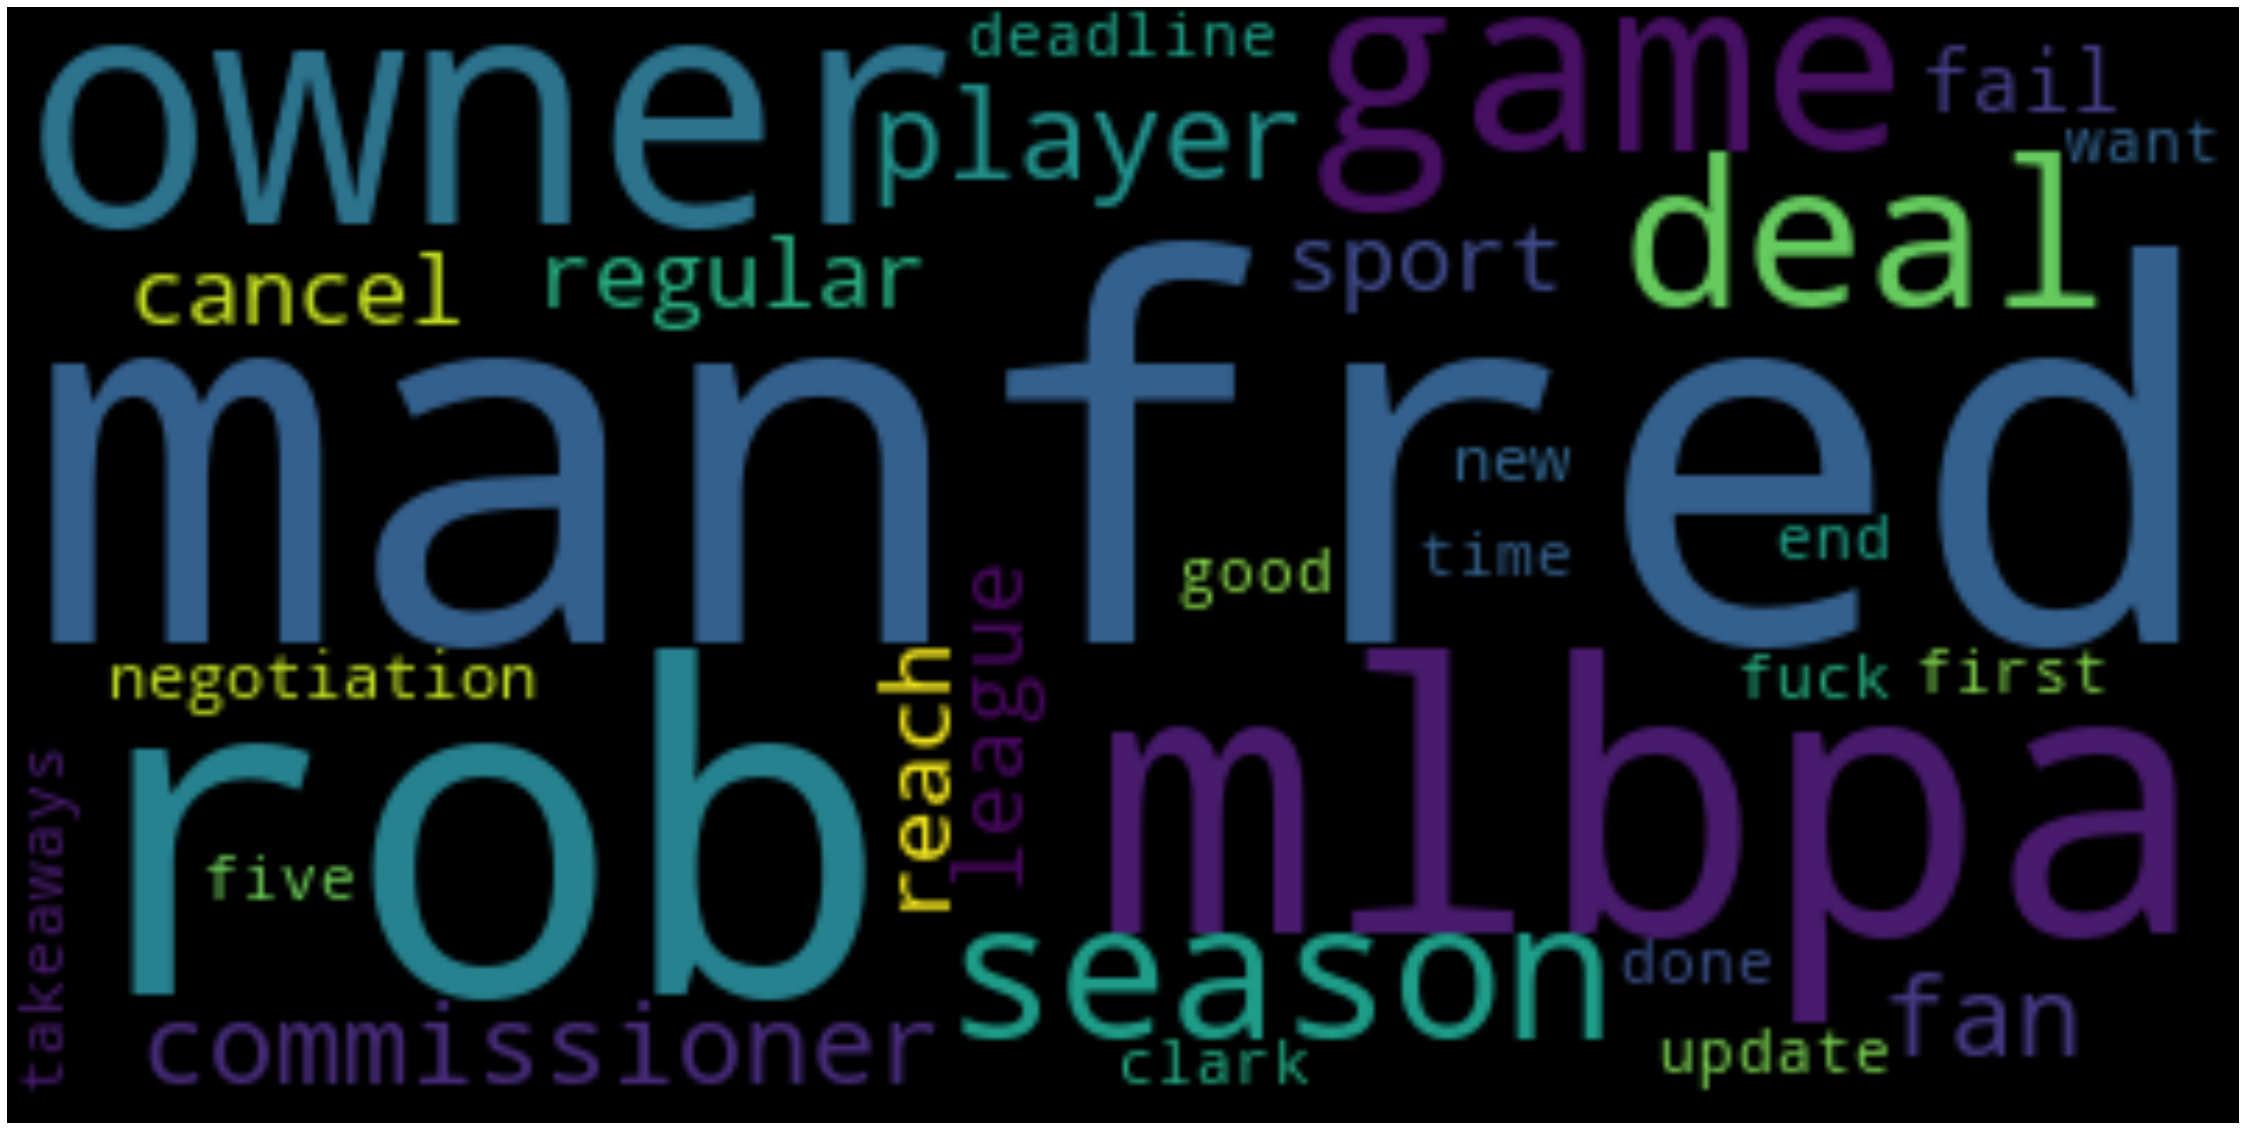

In [ ]:
stopwords = set(STOPWORDS)
stopwords.update(["mlb", "lockout", "mlblockout", "baseball", "today", "day"])
wordcloud = WordCloud(stopwords=stopwords, max_font_size=200,
                      max_words=30, collocations=False, background_color='black').generate(bubble2)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
bubble3 = pd.Series(mlb[mlb.cluster2 == 2].cleaned_text).str.cat(sep=' ')


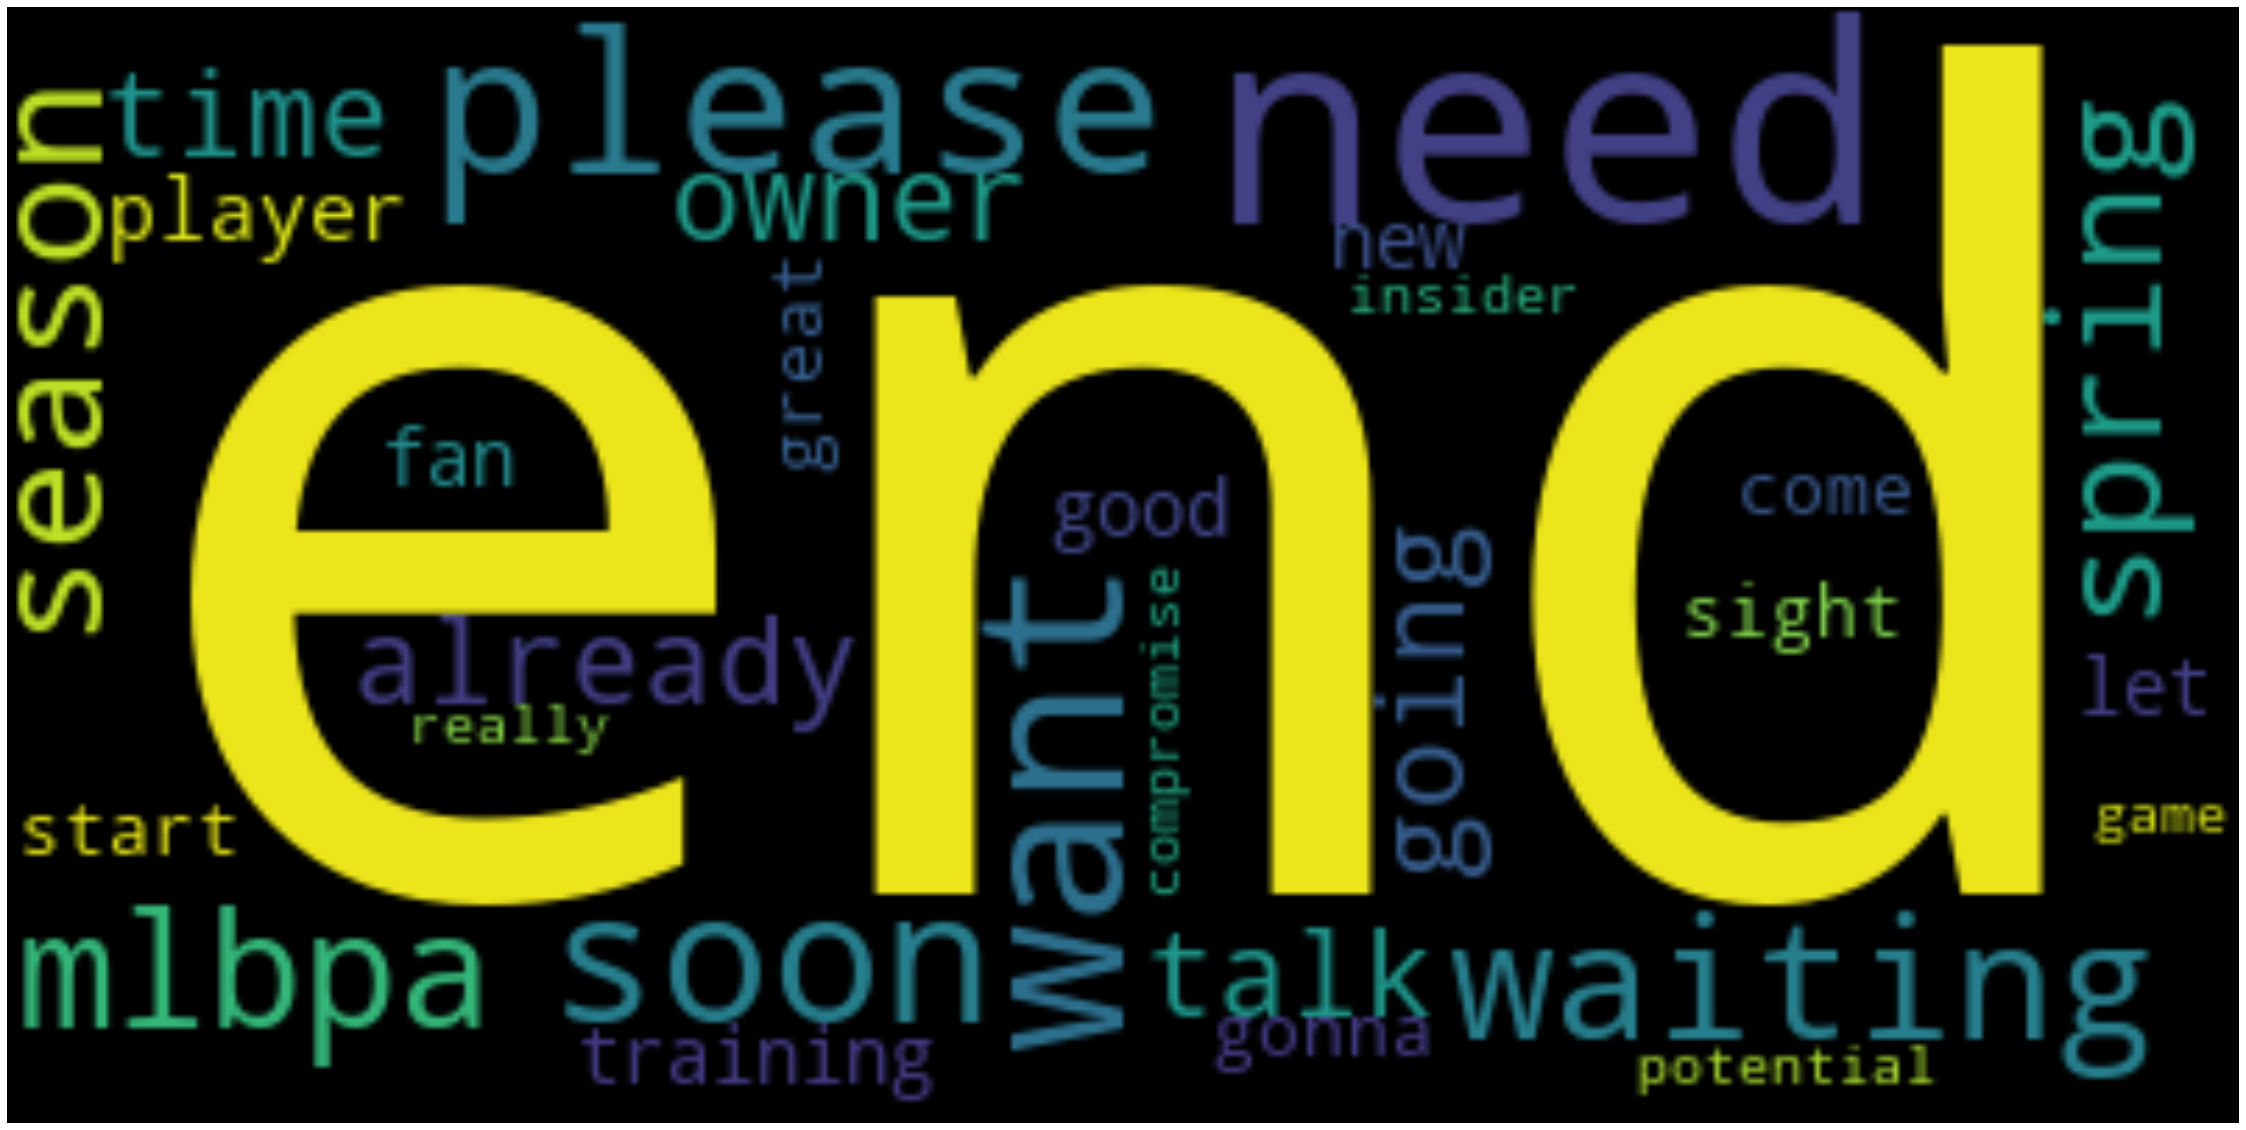

In [ ]:
stopwords = set(STOPWORDS)
stopwords.update(["mlb", "lockout", "mlblockout", "baseball", "today", "day"])
wordcloud = WordCloud(stopwords=stopwords, max_font_size=200,
                      max_words=30, collocations=False, background_color='black').generate(bubble3)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


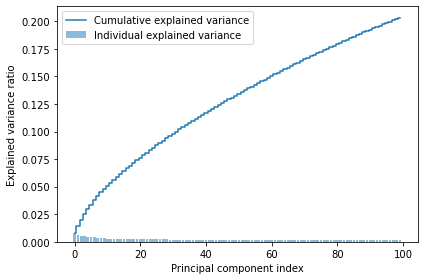

In [ ]:
pca = PCA(n_components=100)
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X.toarray())
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5,
        align='center', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues,
         where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [ ]:
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pca_vecs)
    distortions.append(kmeanModel.inertia_)


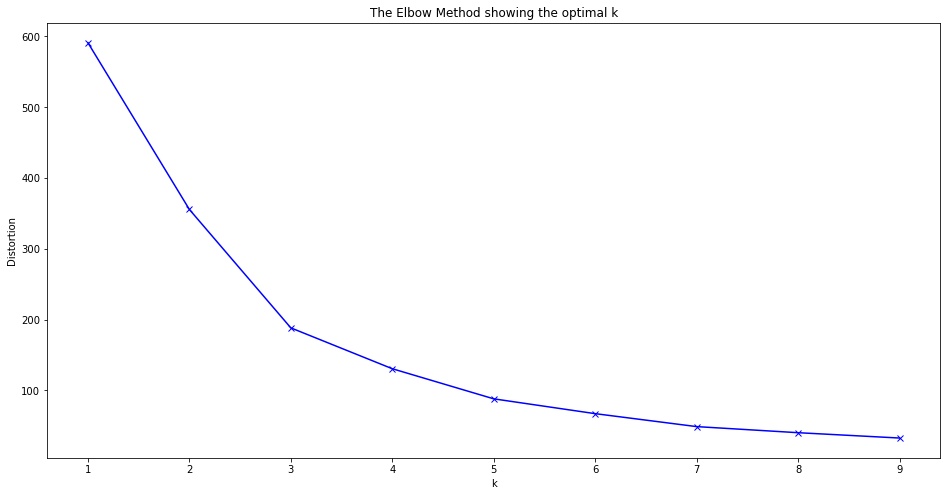

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


## ISOmap

In [ ]:
# initialize PCA with 2 components
# pca = PCA(n_components=1000, random_state=19)
# # pass our X to the pca and store the reduced vectors into pca_vecs
# pca_vecs = pca.fit_transform(X.toarray())
# iso = manifold.Isomap(n_neighbors=50, n_components=2)
# iso2d_map = iso.fit_transform(pca_vecs)


C:\Users\Ernie\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:322: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Ernie\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
# 

NameError: name 'iso' is not defined

In [ ]:
kmeans.fit(pca_vecs)
clusters2 = kmeans.labels_
mlb['cluster2'] = clusters2


## t-SNe

In [10]:
# initialize PCA with 2 components
pca = PCA(n_components=1000, random_state=19)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
tsne = manifold.TSNE(n_components=2)
tsne_map = tsne.fit_transform(pca_vecs)


C:\Users\Ernie\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Ernie\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [11]:
tsne_map.shape

(41243, 2)

In [18]:
kmeans = KMeans(n_clusters=3, random_state=25)
x1 = tsne_map[:,0]
x2 = tsne_map[:,1]
kmeans.fit(tsne_map)
clusters3 = kmeans.labels_
mlb['cluster3'] = clusters3


In [19]:
mlb["x3"] = x1
mlb["x4"] = x2

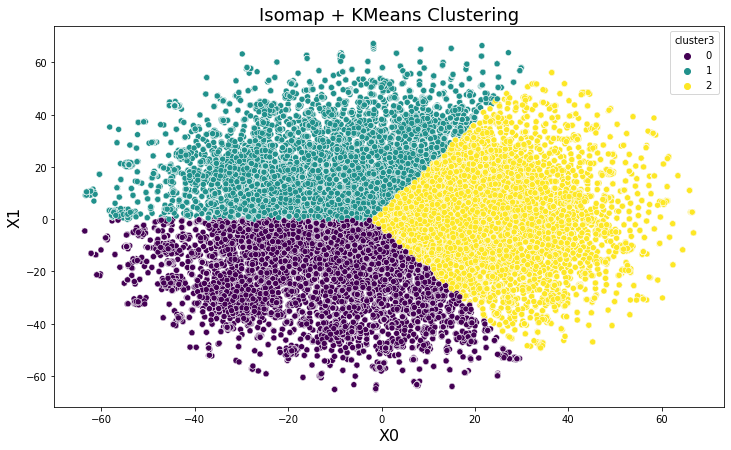

In [20]:
# set image size
plt.figure(figsize=(12, 7))
# set title
plt.title("Isomap + KMeans Clustering",
          fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
#  create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=mlb, x='x3', y='x4', hue='cluster3', palette="viridis")
plt.show()


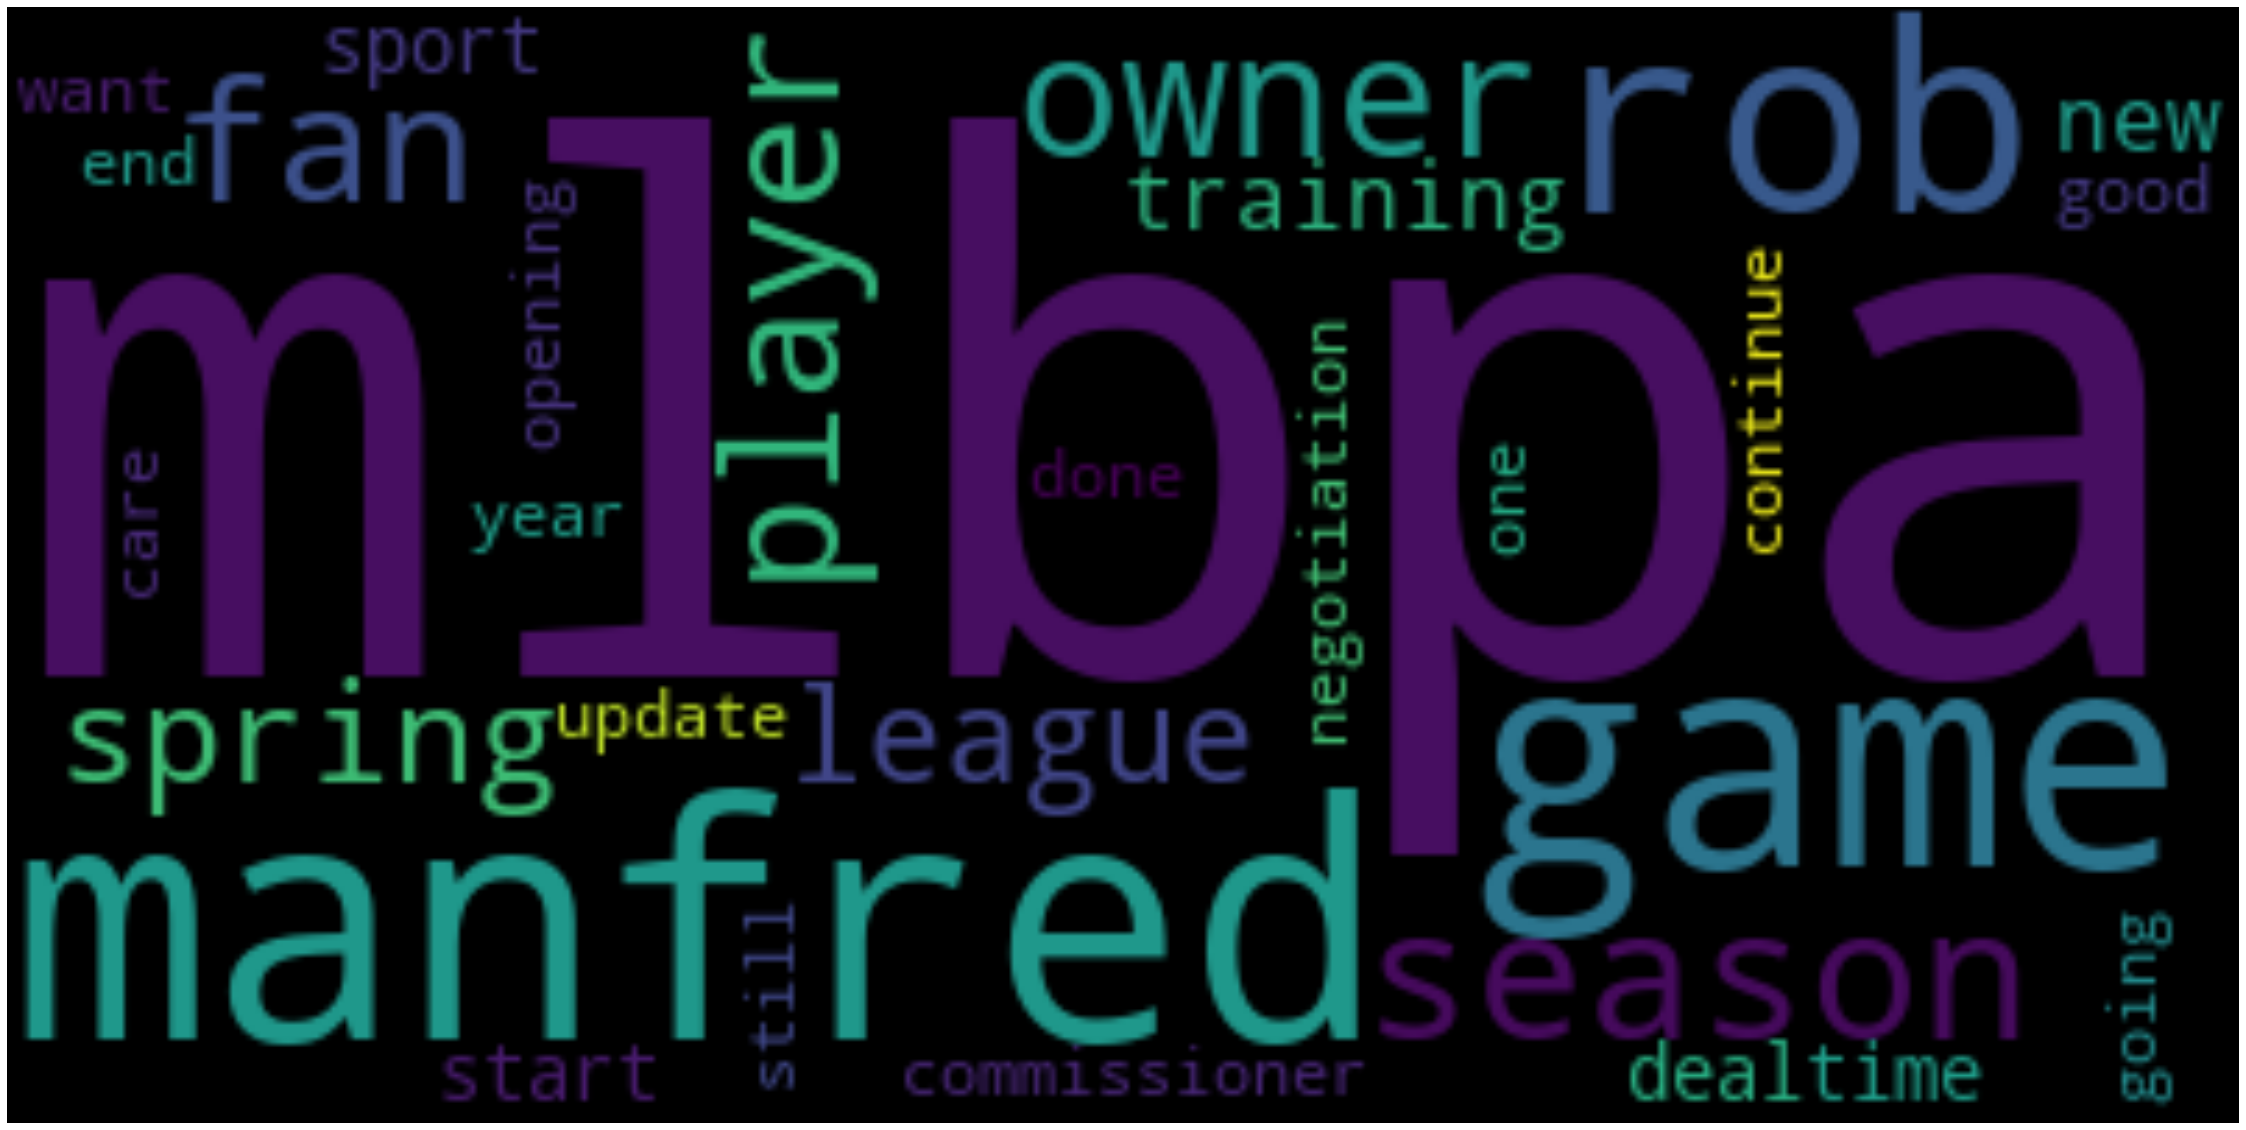

In [34]:
bubble3 = pd.Series(mlb[mlb.cluster3 == 0].cleaned_text).str.cat(sep=' ')
stopwords = set(STOPWORDS)
stopwords.update(["mlb", "lockout", "mlblockout", "baseball", "today", "day"])
wordcloud = WordCloud(stopwords=stopwords, max_font_size=200,
                      max_words=30, collocations=False, background_color='black').generate(bubble3)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


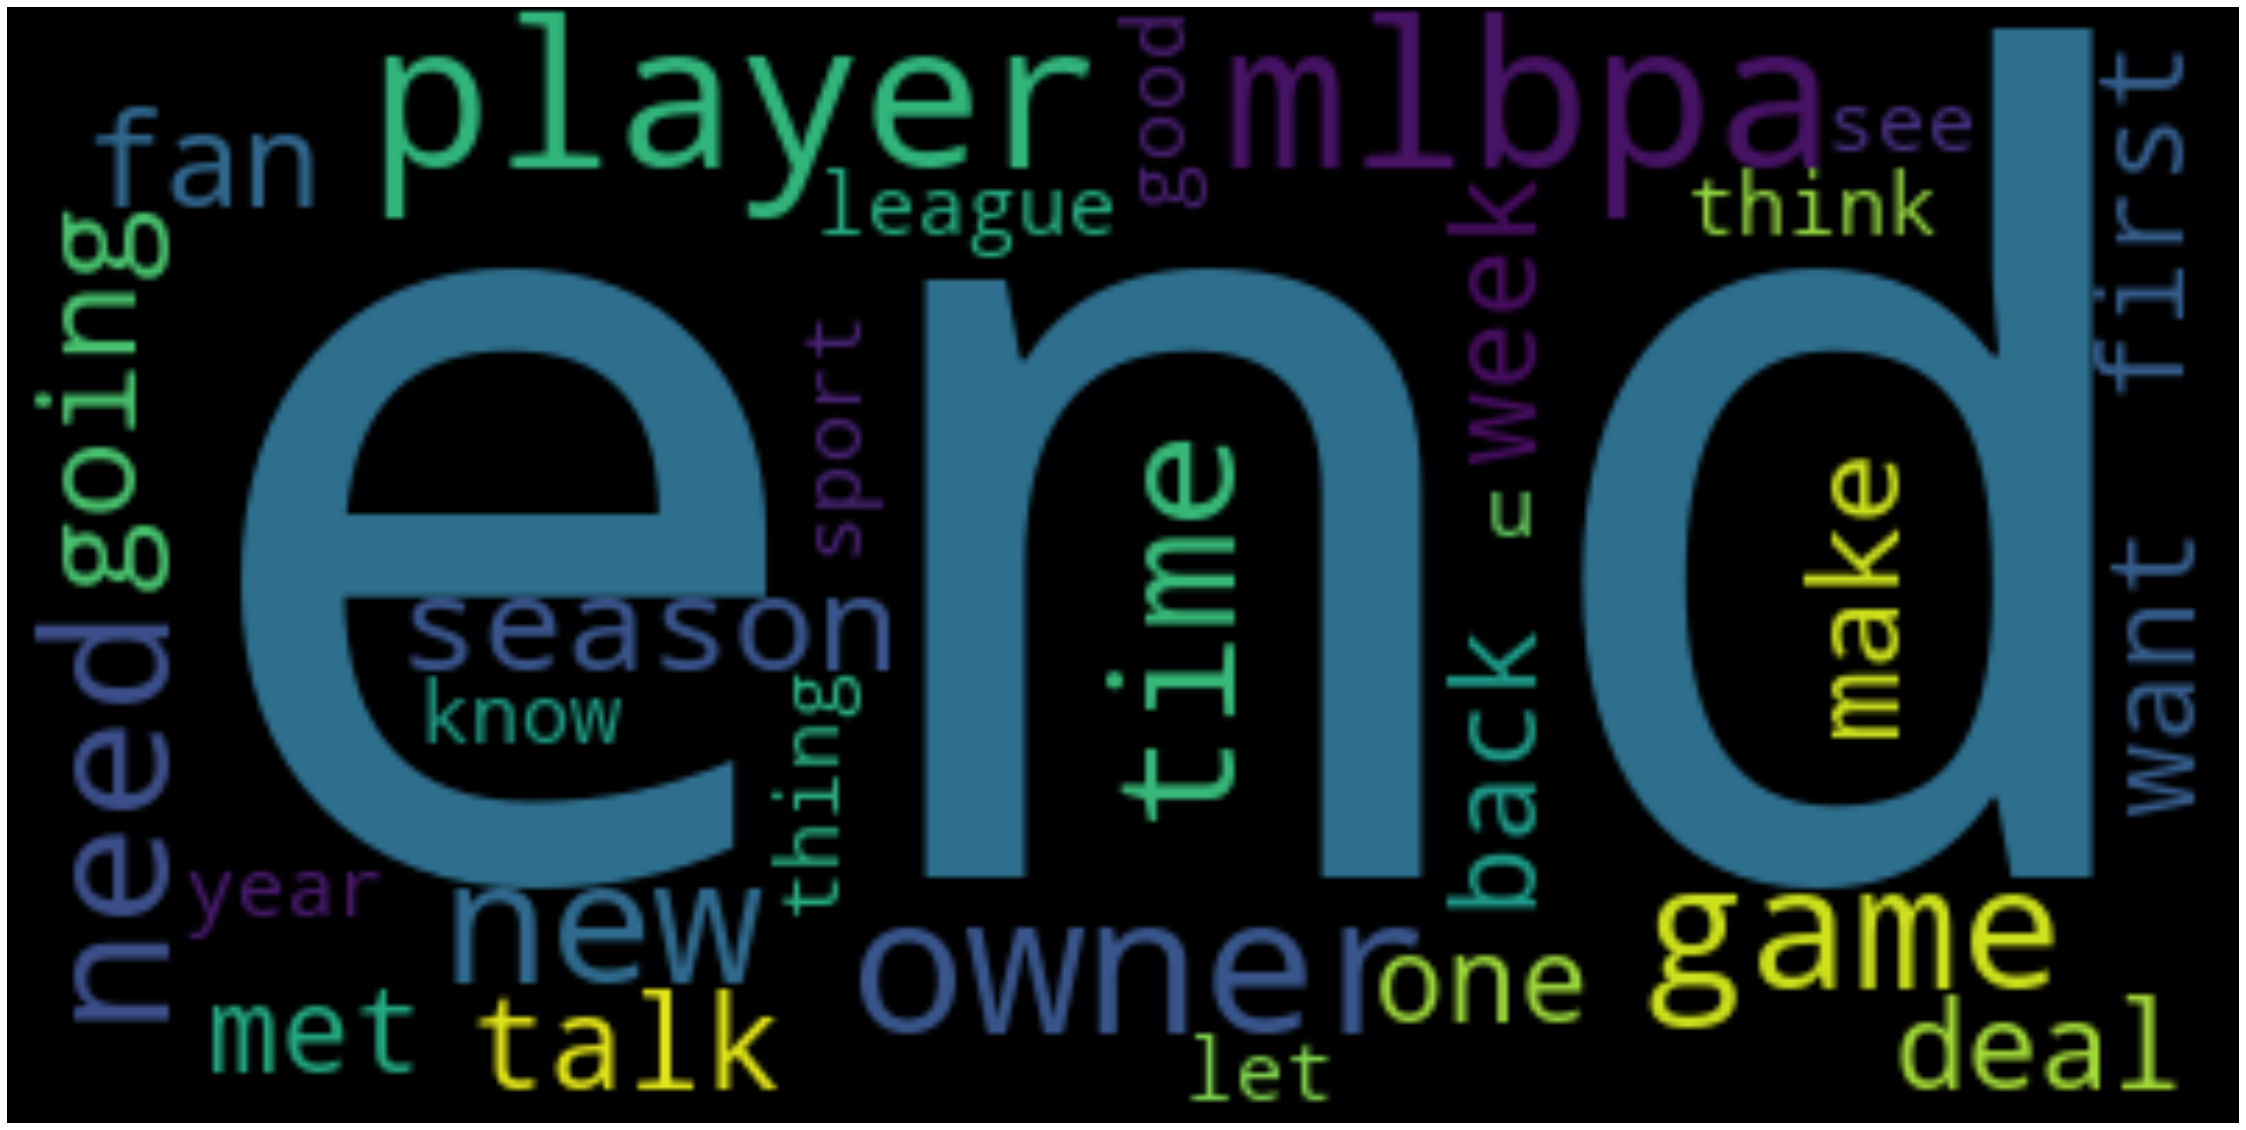

In [35]:
bubble3 = pd.Series(mlb[mlb.cluster3 == 1].cleaned_text).str.cat(sep=' ')
stopwords = set(STOPWORDS)
stopwords.update(["mlb", "lockout", "mlblockout", "baseball", "today", "day"])
wordcloud = WordCloud(stopwords=stopwords, max_font_size=200,
                      max_words=30, collocations=False, background_color='black').generate(bubble3)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

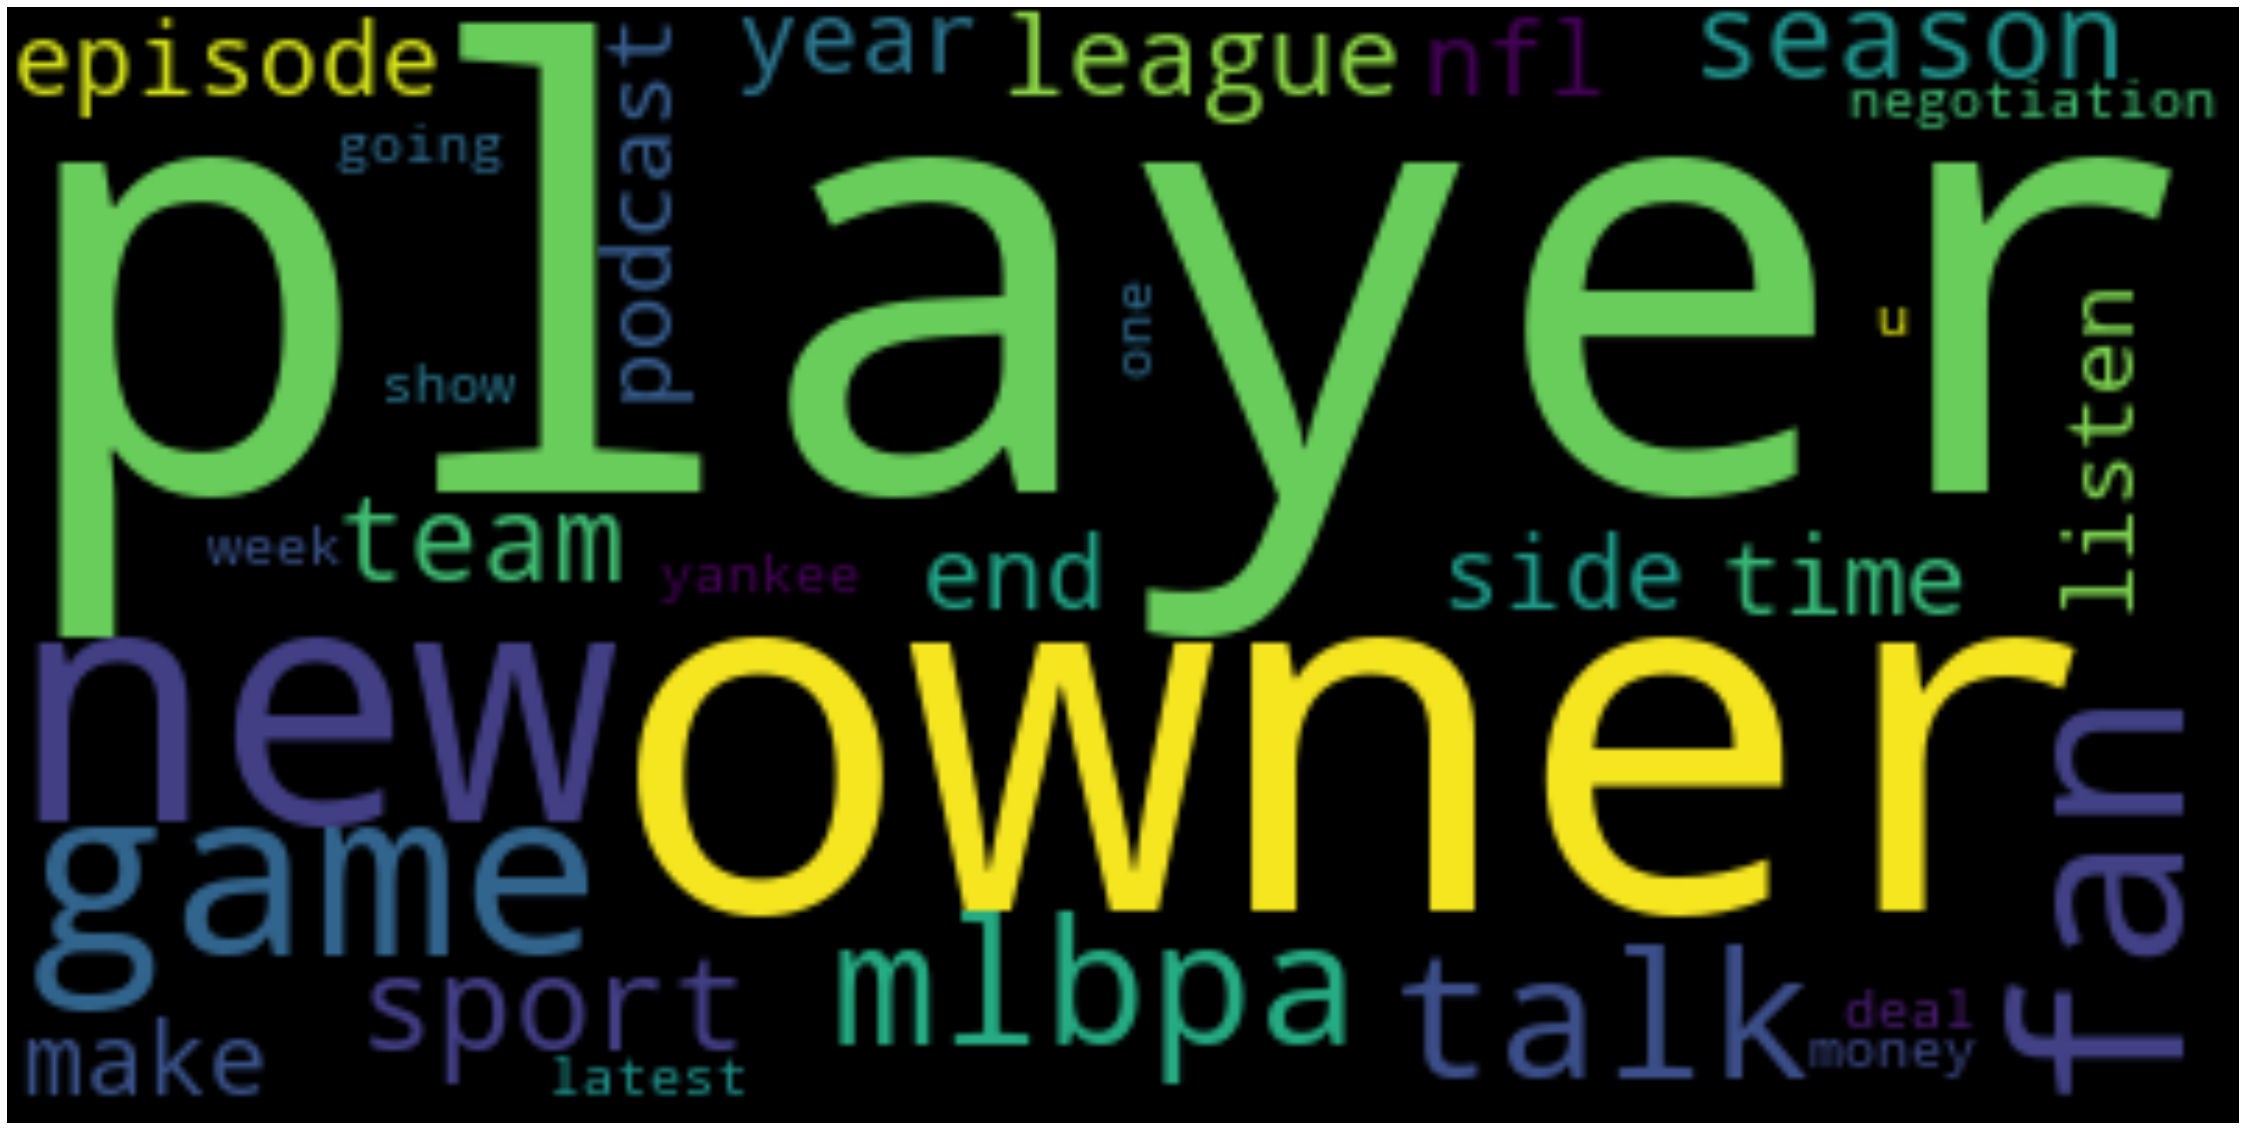

In [36]:
bubble3 = pd.Series(mlb[mlb.cluster3 == 2].cleaned_text).str.cat(sep=' ')
stopwords = set(STOPWORDS)
stopwords.update(["mlb", "lockout", "mlblockout", "baseball", "today", "day"])
wordcloud = WordCloud(stopwords=stopwords, max_font_size=200,
                      max_words=30, collocations=False, background_color='black').generate(bubble3)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [26]:
dbs = DBSCAN(eps=3, min_samples=2)
x1 = tsne_map[:,0]
x2 = tsne_map[:,1]
dbs.fit(tsne_map)
clusters4 = dbs.labels_
mlb['cluster4'] = clusters4


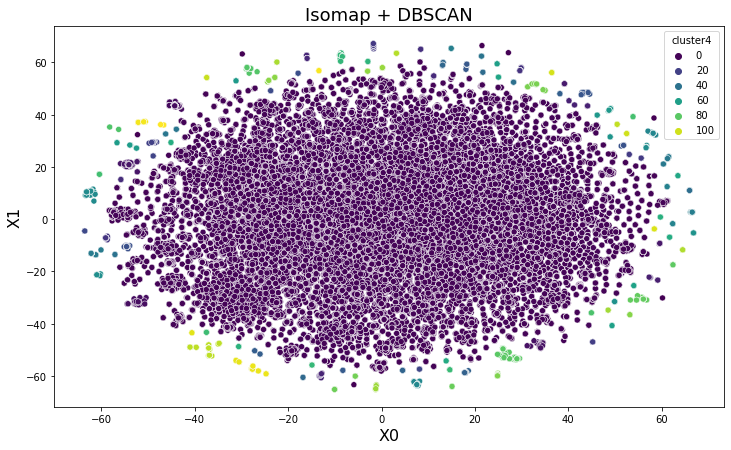

In [27]:
# set image size
plt.figure(figsize=(12, 7))
# set title
plt.title("Isomap + DBSCAN",
          fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
#  create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=mlb, x='x3', y='x4', hue='cluster4', palette="viridis")
plt.show()


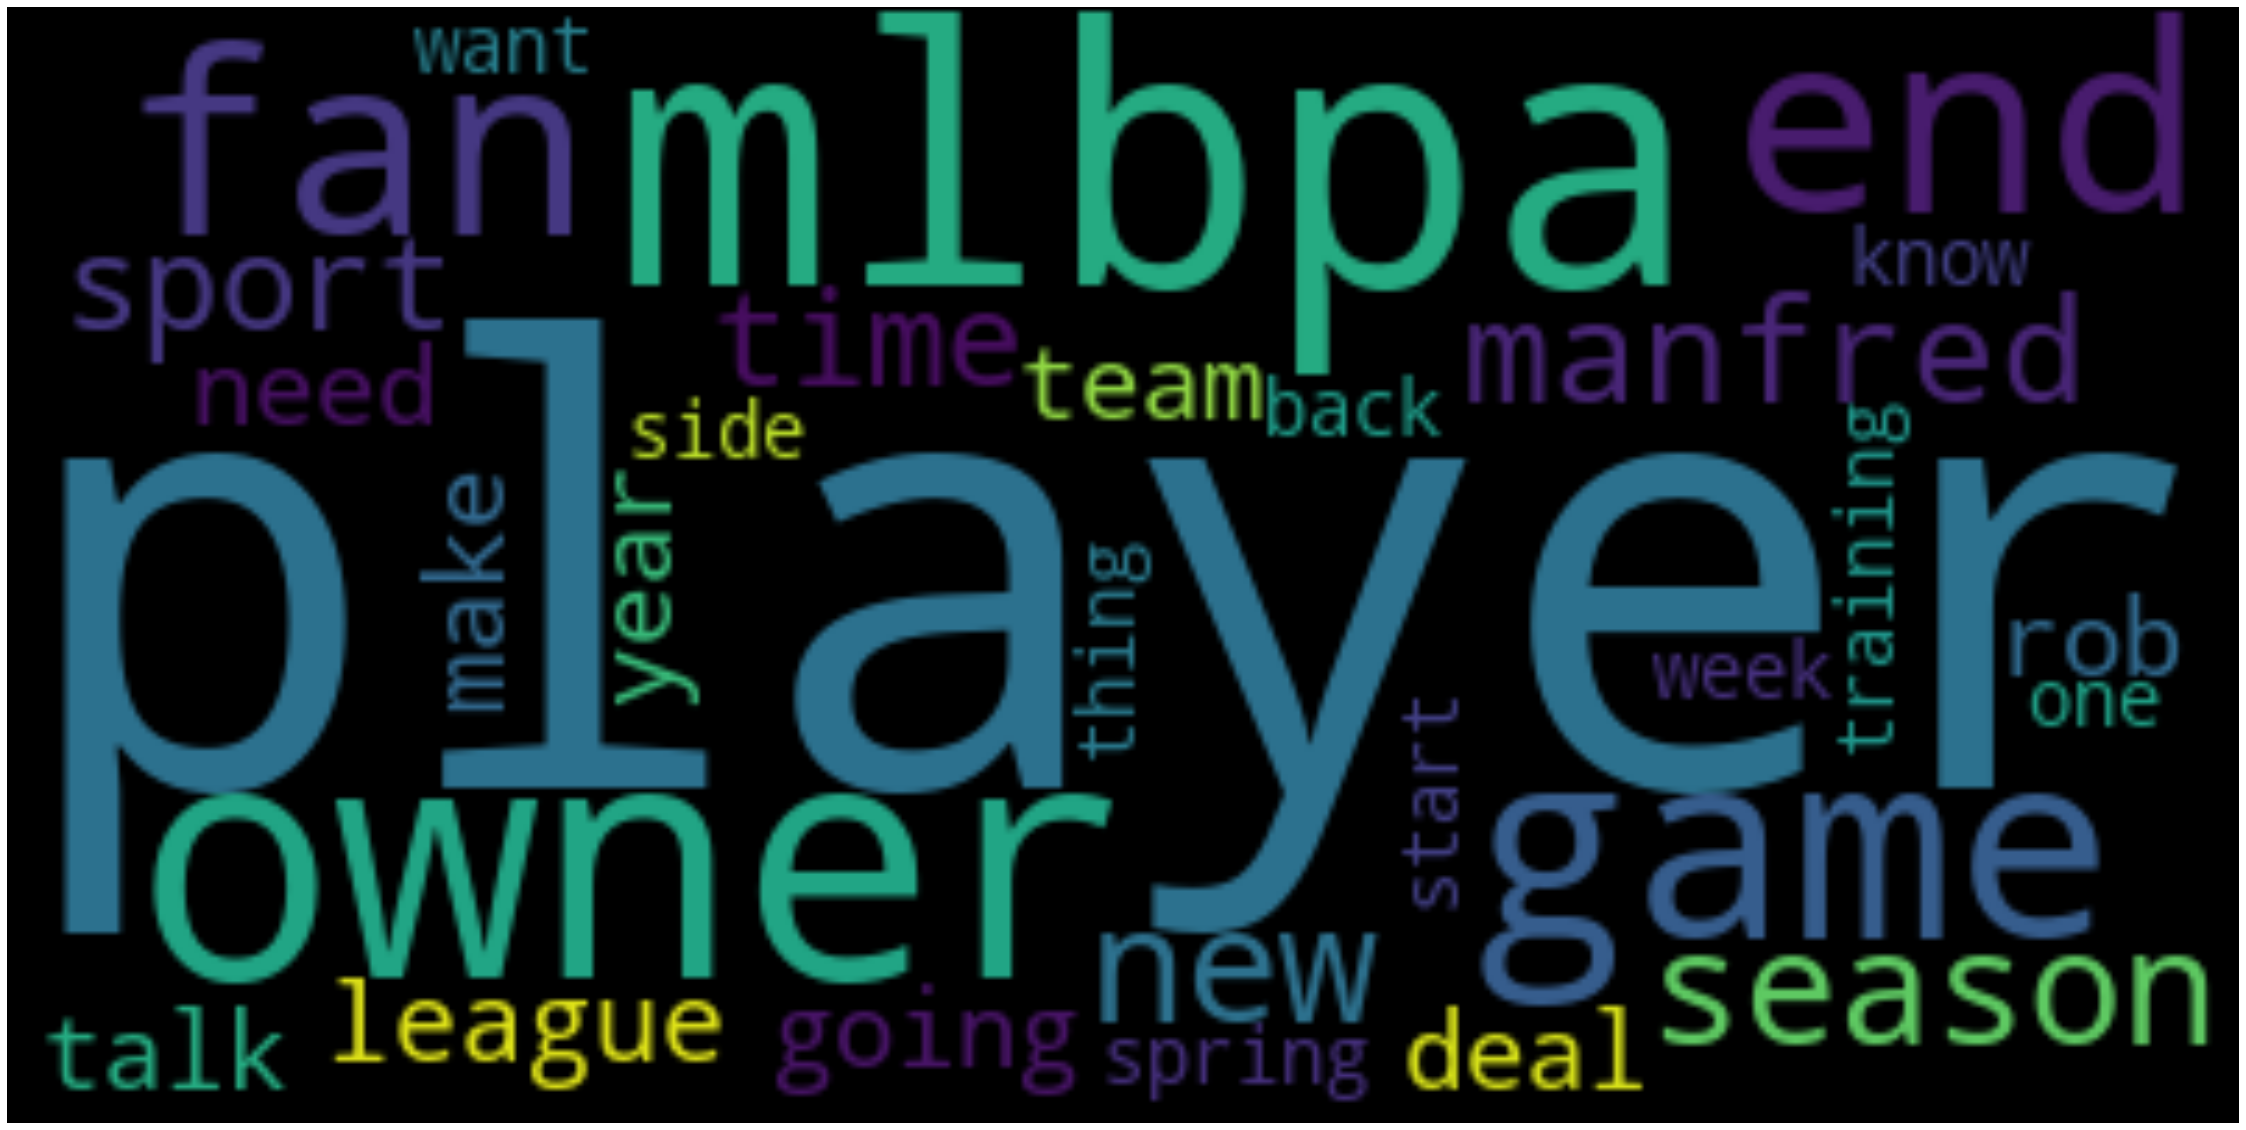

In [33]:
bubble4 = pd.Series(mlb[mlb.cluster4 == 0].cleaned_text).str.cat(sep=' ')
stopwords = set(STOPWORDS)
stopwords.update(["mlb", "lockout", "mlblockout", "baseball", "today", "day"])
wordcloud = WordCloud(stopwords=stopwords, max_font_size=200,
                      max_words=30, collocations=False, background_color='black').generate(bubble4)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [37]:
dbs = DBSCAN(eps=3, min_samples=2)
dbs.fit(pca_vecs)
clusters7 = dbs.labels_
mlb['cluster7'] = clusters7


ValueError: Could not interpret value `x0` for parameter `x`

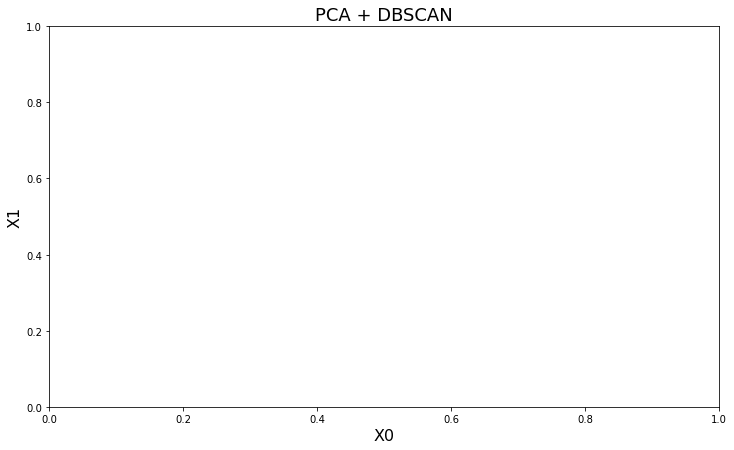

In [38]:
# set image size
plt.figure(figsize=(12, 7))
# set title
plt.title("PCA + DBSCAN",
          fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
#  create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=mlb, x='x0', y='x1', hue='cluster7', palette="viridis")
plt.show()

In [32]:
# np.unique(dbs.labels_)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
dbs = DBSCAN()
dbs.fit(tsne_map)
clusters4 = kmeans.labels_
mlb['cluster4'] = clusters4


## Specteral Clustering

In [ ]:
# sc = SpectralClustering(n_clusters=3, random_state=25)
# sc.fit(pca_vecs)
# clusters3 = sc.labels_


In [ ]:
# clusters3

## DBSCAN